In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import warnings

# Filter out all warnings
warnings.filterwarnings("ignore")

In [2]:
!gdown 1UQoPrudCqe-Fr-WDXA7lWNhp0JcHT8WB

Downloading...
From: https://drive.google.com/uc?id=1UQoPrudCqe-Fr-WDXA7lWNhp0JcHT8WB
To: /content/data.csv
100% 2.14M/2.14M [00:00<00:00, 48.4MB/s]


In [3]:
!ls

data.csv  sample_data


In [4]:
df = pd.read_csv('data.csv')

In [5]:
df.head()

id  sale_no                   created_date_ad  grand_total
0      9       53  2022-07-19 11:09:33.905637+05:45         10.0
1  12414    12345  2022-11-15 09:48:58.892703+05:45         25.0
2     11       55  2022-07-19 11:12:53.626743+05:45         10.0
3     12       56  2022-07-19 11:13:32.552725+05:45         10.0
4     13       57  2022-07-19 11:14:12.112063+05:45         10.0

In [6]:
df['created_date_ad']=pd.to_datetime(df['created_date_ad'])

In [7]:
df.set_index('created_date_ad', inplace=True)
daily_df = df.resample('D').sum()
daily_df

id  sale_no  grand_total
created_date_ad                                         
2022-07-19 00:00:00+05:45     6100    10588       9060.0
2022-07-20 00:00:00+05:45    16150    20044       8955.0
2022-07-21 00:00:00+05:45    39762    45684      10150.0
2022-07-22 00:00:00+05:45    73332    77613      13160.0
2022-07-23 00:00:00+05:45        0        0          0.0
...                            ...      ...          ...
2023-06-06 00:00:00+05:45  6455652  6198604      19555.0
2023-06-07 00:00:00+05:45  6251823  6110196      19040.0
2023-06-08 00:00:00+05:45  4337592  4227843      12480.0
2023-06-09 00:00:00+05:45  5673195  5427675      17915.0
2023-06-10 00:00:00+05:45   233601   229713        150.0

[327 rows x 3 columns]

In [8]:
daily_df.index

DatetimeIndex(['2022-07-19 00:00:00+05:45', '2022-07-20 00:00:00+05:45',
               '2022-07-21 00:00:00+05:45', '2022-07-22 00:00:00+05:45',
               '2022-07-23 00:00:00+05:45', '2022-07-24 00:00:00+05:45',
               '2022-07-25 00:00:00+05:45', '2022-07-26 00:00:00+05:45',
               '2022-07-27 00:00:00+05:45', '2022-07-28 00:00:00+05:45',
               ...
               '2023-06-01 00:00:00+05:45', '2023-06-02 00:00:00+05:45',
               '2023-06-03 00:00:00+05:45', '2023-06-04 00:00:00+05:45',
               '2023-06-05 00:00:00+05:45', '2023-06-06 00:00:00+05:45',
               '2023-06-07 00:00:00+05:45', '2023-06-08 00:00:00+05:45',
               '2023-06-09 00:00:00+05:45', '2023-06-10 00:00:00+05:45'],
              dtype='datetime64[ns, UTC+05:45]', name='created_date_ad', length=327, freq='D')

In [9]:
df = daily_df.drop(columns=['id', 'sale_no'])
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['grand_total'] = daily_df['grand_total']

df.head()

grand_total  year  month  day
created_date_ad                                         
2022-07-19 00:00:00+05:45       9060.0  2022      7   19
2022-07-20 00:00:00+05:45       8955.0  2022      7   20
2022-07-21 00:00:00+05:45      10150.0  2022      7   21
2022-07-22 00:00:00+05:45      13160.0  2022      7   22
2022-07-23 00:00:00+05:45          0.0  2022      7   23

In [10]:
df.reset_index(inplace=True)


In [11]:
df.head()

created_date_ad  grand_total  year  month  day
0 2022-07-19 00:00:00+05:45       9060.0  2022      7   19
1 2022-07-20 00:00:00+05:45       8955.0  2022      7   20
2 2022-07-21 00:00:00+05:45      10150.0  2022      7   21
3 2022-07-22 00:00:00+05:45      13160.0  2022      7   22
4 2022-07-23 00:00:00+05:45          0.0  2022      7   23

In [12]:
df.drop(['created_date_ad'], axis = 1, inplace = True)

In [13]:

df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df['is_saturday'] = (df['date'].dt.weekday == 5).astype(int)

df

grand_total  year  month  day       date  is_saturday
0         9060.0  2022      7   19 2022-07-19            0
1         8955.0  2022      7   20 2022-07-20            0
2        10150.0  2022      7   21 2022-07-21            0
3        13160.0  2022      7   22 2022-07-22            0
4            0.0  2022      7   23 2022-07-23            1
..           ...   ...    ...  ...        ...          ...
322      19555.0  2023      6    6 2023-06-06            0
323      19040.0  2023      6    7 2023-06-07            0
324      12480.0  2023      6    8 2023-06-08            0
325      17915.0  2023      6    9 2023-06-09            0
326        150.0  2023      6   10 2023-06-10            1

[327 rows x 6 columns]

In [14]:
df.describe().T

count                 mean                  min  \
grand_total  327.0          8895.070336                  0.0   
year         327.0          2022.492355               2022.0   
month        327.0              6.53211                  1.0   
day          327.0            15.770642                  1.0   
date           327  2022-12-29 00:00:00  2022-07-19 00:00:00   
is_saturday  327.0             0.143731                  0.0   

                             25%                  50%                  75%  \
grand_total                420.0               9060.0              14092.5   
year                      2022.0               2022.0               2023.0   
month                        3.0                  7.0                 10.0   
day                          8.0                 16.0                 23.5   
date         2022-10-08 12:00:00  2022-12-29 00:00:00  2023-03-20 12:00:00   
is_saturday                  0.0                  0.0                  0.0   

                             max          std  
grand_total              28710.0  7123.151842  
year                      2023.0     0.500708  
month                       12.0     3.644229  
day                         31.0     8.919854  
date         2023-06-10 00:00:00          NaN  
is_saturday                  1.0     0.351354

# Trying out different models on our data ARIMA, SARIMA, XGBoost, Linear Regression

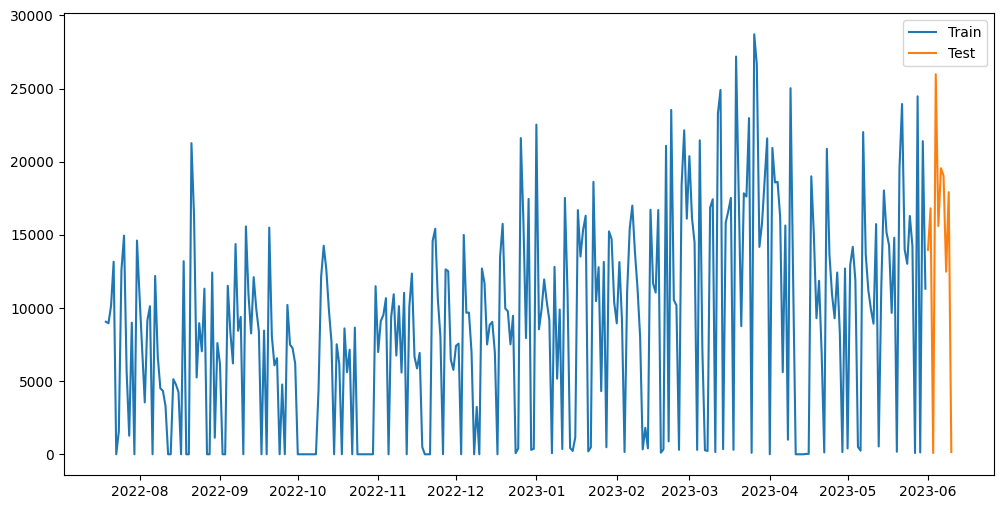

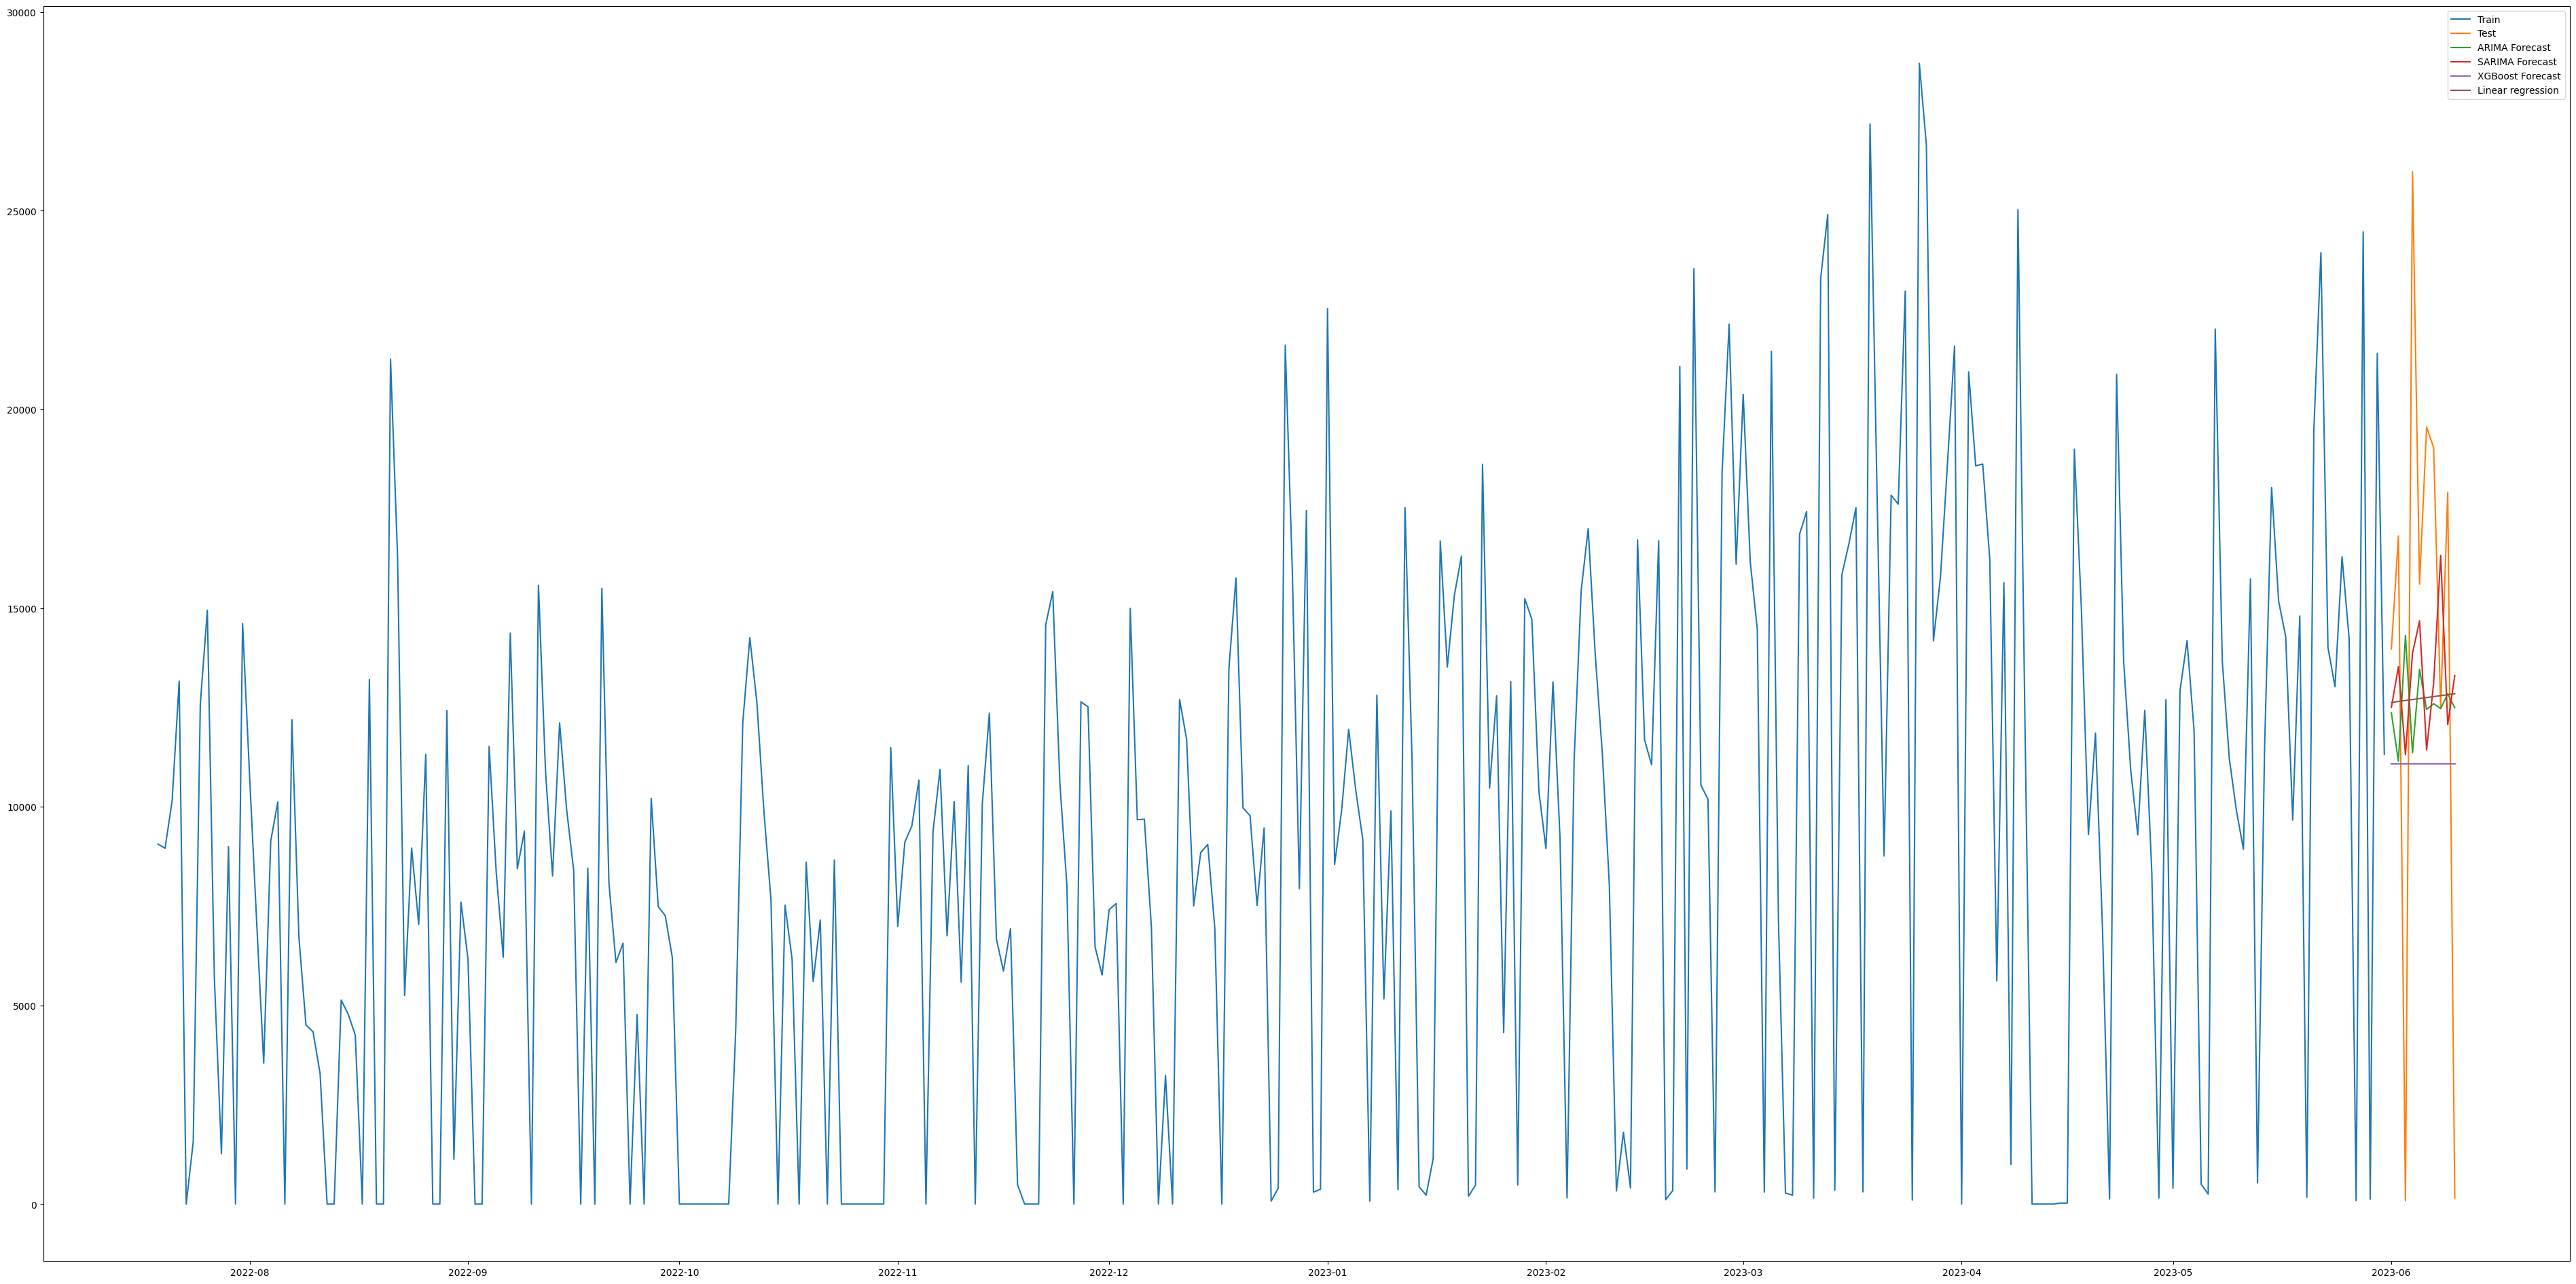

ARIMA Model Evaluation:
RMSE: 8517.890629803334
R²: -0.18337611414735377

SARIMA Model Evaluation:
RMSE: 7809.3472885005485
R²: 0.005309079756014468

XGBoost Model Evaluation:
RMSE: 8415.500177410335
R²: -0.15509724269959846

 Linear regression Model Evaluation:
RMSE: 7969.9173607042785
R²: -0.036015651987456154


In [15]:

# Ensure 'date' is in datetime format and set it as index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Split the data
train = df[df.index < '2023-06-01']
test = df[df.index >= '2023-06-01']

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(train['grand_total'], label='Train')
plt.plot(test['grand_total'], label='Test')
plt.legend()
plt.show()

# Define function to evaluate models
def evaluate_model(true, predicted):
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(true, predicted)
    print(f'RMSE: {rmse}')
    print(f'R²: {r2}')
    return rmse, r2

# ARIMA Model
arima_order = (5, 1, 0)
arima_model = ARIMA(train['grand_total'], order=arima_order)
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(test))

# SARIMA Model
sarima_order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)
sarima_model = SARIMAX(train['grand_total'], order=sarima_order, seasonal_order=seasonal_order)
sarima_fit = sarima_model.fit()
sarima_forecast = sarima_fit.forecast(steps=len(test))

# XGBoost Model
x_train = np.arange(len(train)).reshape(-1, 1)
x_test = np.arange(len(train), len(train) + len(test)).reshape(-1, 1)
y_train = train['grand_total']

xgb_model = XGBRegressor(objective='reg:squarederror')
xgb_model.fit(x_train, y_train)
xgb_forecast = xgb_model.predict(x_test)


linear_model = LinearRegression()
linear_model.fit(x_train, y_train)
linear_forecast = linear_model.predict(x_test)

# Plot the forecasts
plt.figure(figsize=(48, 24))
plt.plot(train['grand_total'], label='Train')
plt.plot(test['grand_total'], label='Test')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast')
plt.plot(test.index, xgb_forecast, label='XGBoost Forecast')
plt.plot(test.index, linear_forecast, label = 'Linear regression')
plt.legend()
plt.show()

# Evaluate the models
print("ARIMA Model Evaluation:")
arima_rmse, arima_r2 = evaluate_model(test['grand_total'], arima_forecast)

print("\nSARIMA Model Evaluation:")
sarima_rmse, sarima_r2 = evaluate_model(test['grand_total'], sarima_forecast)

print("\nXGBoost Model Evaluation:")
xgb_rmse, xgb_r2 = evaluate_model(test['grand_total'], xgb_forecast)

print("\n Linear regression Model Evaluation:")
lin_rmse, lin_r2 = evaluate_model(test['grand_total'], linear_forecast)


# XGBoost with its parameters tuned using Gridsearch

In [31]:
"""

# Split the data
train = df[df.index < '2023-06-01']
test = df[df.index >= '2023-06-01']

x_train = np.arange(len(train)).reshape(-1, 1)
x_test = np.arange(len(train), len(train) + len(test)).reshape(-1, 1)
y_train = train['grand_total']

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'alpha': [0, 0.1, 0.5]
}

# Use TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the XGBRegressor
xgb_model = XGBRegressor(objective='reg:squarederror')

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(x_train, y_train)

# Get the best model
best_xgb_model = grid_search.best_estimator_
print("Best Parameters: ", grid_search.best_params_)

# Predict using the best model
xgb_forecast = best_xgb_model.predict(x_test)

# Plot the forecasts
plt.figure(figsize=(12, 6))
plt.plot(train['grand_total'], label='Train')
plt.plot(test['grand_total'], label='Test')
plt.plot(test.index, xgb_forecast, label='XGBoost Forecast')
plt.title('XGBoost Model Forecast')
plt.legend()
plt.show()

# Evaluate the model
print("XGBoost Model Evaluation:")
def evaluate_model(true, predicted):
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(true, predicted)
    print(f'RMSE: {rmse}')
    print(f'R²: {r2}')
    return rmse, r2

xgb_rmse, xgb_r2 = evaluate_model(test['grand_total'], xgb_forecast)



"""

'\n\n# Split the data\ntrain = df[df.index < \'2023-06-01\']\ntest = df[df.index >= \'2023-06-01\']\n\nx_train = np.arange(len(train)).reshape(-1, 1)\nx_test = np.arange(len(train), len(train) + len(test)).reshape(-1, 1)\ny_train = train[\'grand_total\']\n\n# Define the parameter grid for hyperparameter tuning\nparam_grid = {\n    \'n_estimators\': [50, 100, 200],\n    \'max_depth\': [3, 5, 7],\n    \'learning_rate\': [0.01, 0.05, 0.1],\n    \'subsample\': [0.6, 0.8, 1.0],\n    \'colsample_bytree\': [0.6, 0.8, 1.0],\n    \'alpha\': [0, 0.1, 0.5]\n}\n\n# Use TimeSeriesSplit for cross-validation\ntscv = TimeSeriesSplit(n_splits=5)\n\n# Initialize the XGBRegressor\nxgb_model = XGBRegressor(objective=\'reg:squarederror\')\n\n# Perform GridSearchCV\ngrid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=tscv, scoring=\'neg_mean_squared_error\', n_jobs=-1)\ngrid_search.fit(x_train, y_train)\n\n# Get the best model\nbest_xgb_model = grid_search.best_estimator_\nprint("Best 

# **LSTM with highest R2 coefficient score and lowest scaled MSE**

Epoch 1/100
307/307 [==============================] - 8s 13ms/step - loss: 0.0582
Epoch 2/100
307/307 [==============================] - 3s 9ms/step - loss: 0.0601
Epoch 3/100
307/307 [==============================] - 2s 8ms/step - loss: 0.0578
Epoch 4/100
307/307 [==============================] - 3s 9ms/step - loss: 0.0523
Epoch 5/100
307/307 [==============================] - 3s 8ms/step - loss: 0.0508
Epoch 6/100
307/307 [==============================] - 3s 9ms/step - loss: 0.0489
Epoch 7/100
307/307 [==============================] - 3s 9ms/step - loss: 0.0504
Epoch 8/100
307/307 [==============================] - 3s 10ms/step - loss: 0.0487
Epoch 9/100
307/307 [==============================] - 3s 9ms/step - loss: 0.0477
Epoch 10/100
307/307 [==============================] - 3s 8ms/step - loss: 0.0484
Epoch 11/100
307/307 [==============================] - 3s 8ms/step - loss: 0.0477
Epoch 12/100
307/307 [==============================] - 3s 9ms/step - loss: 0.0481
Epoch 13/10

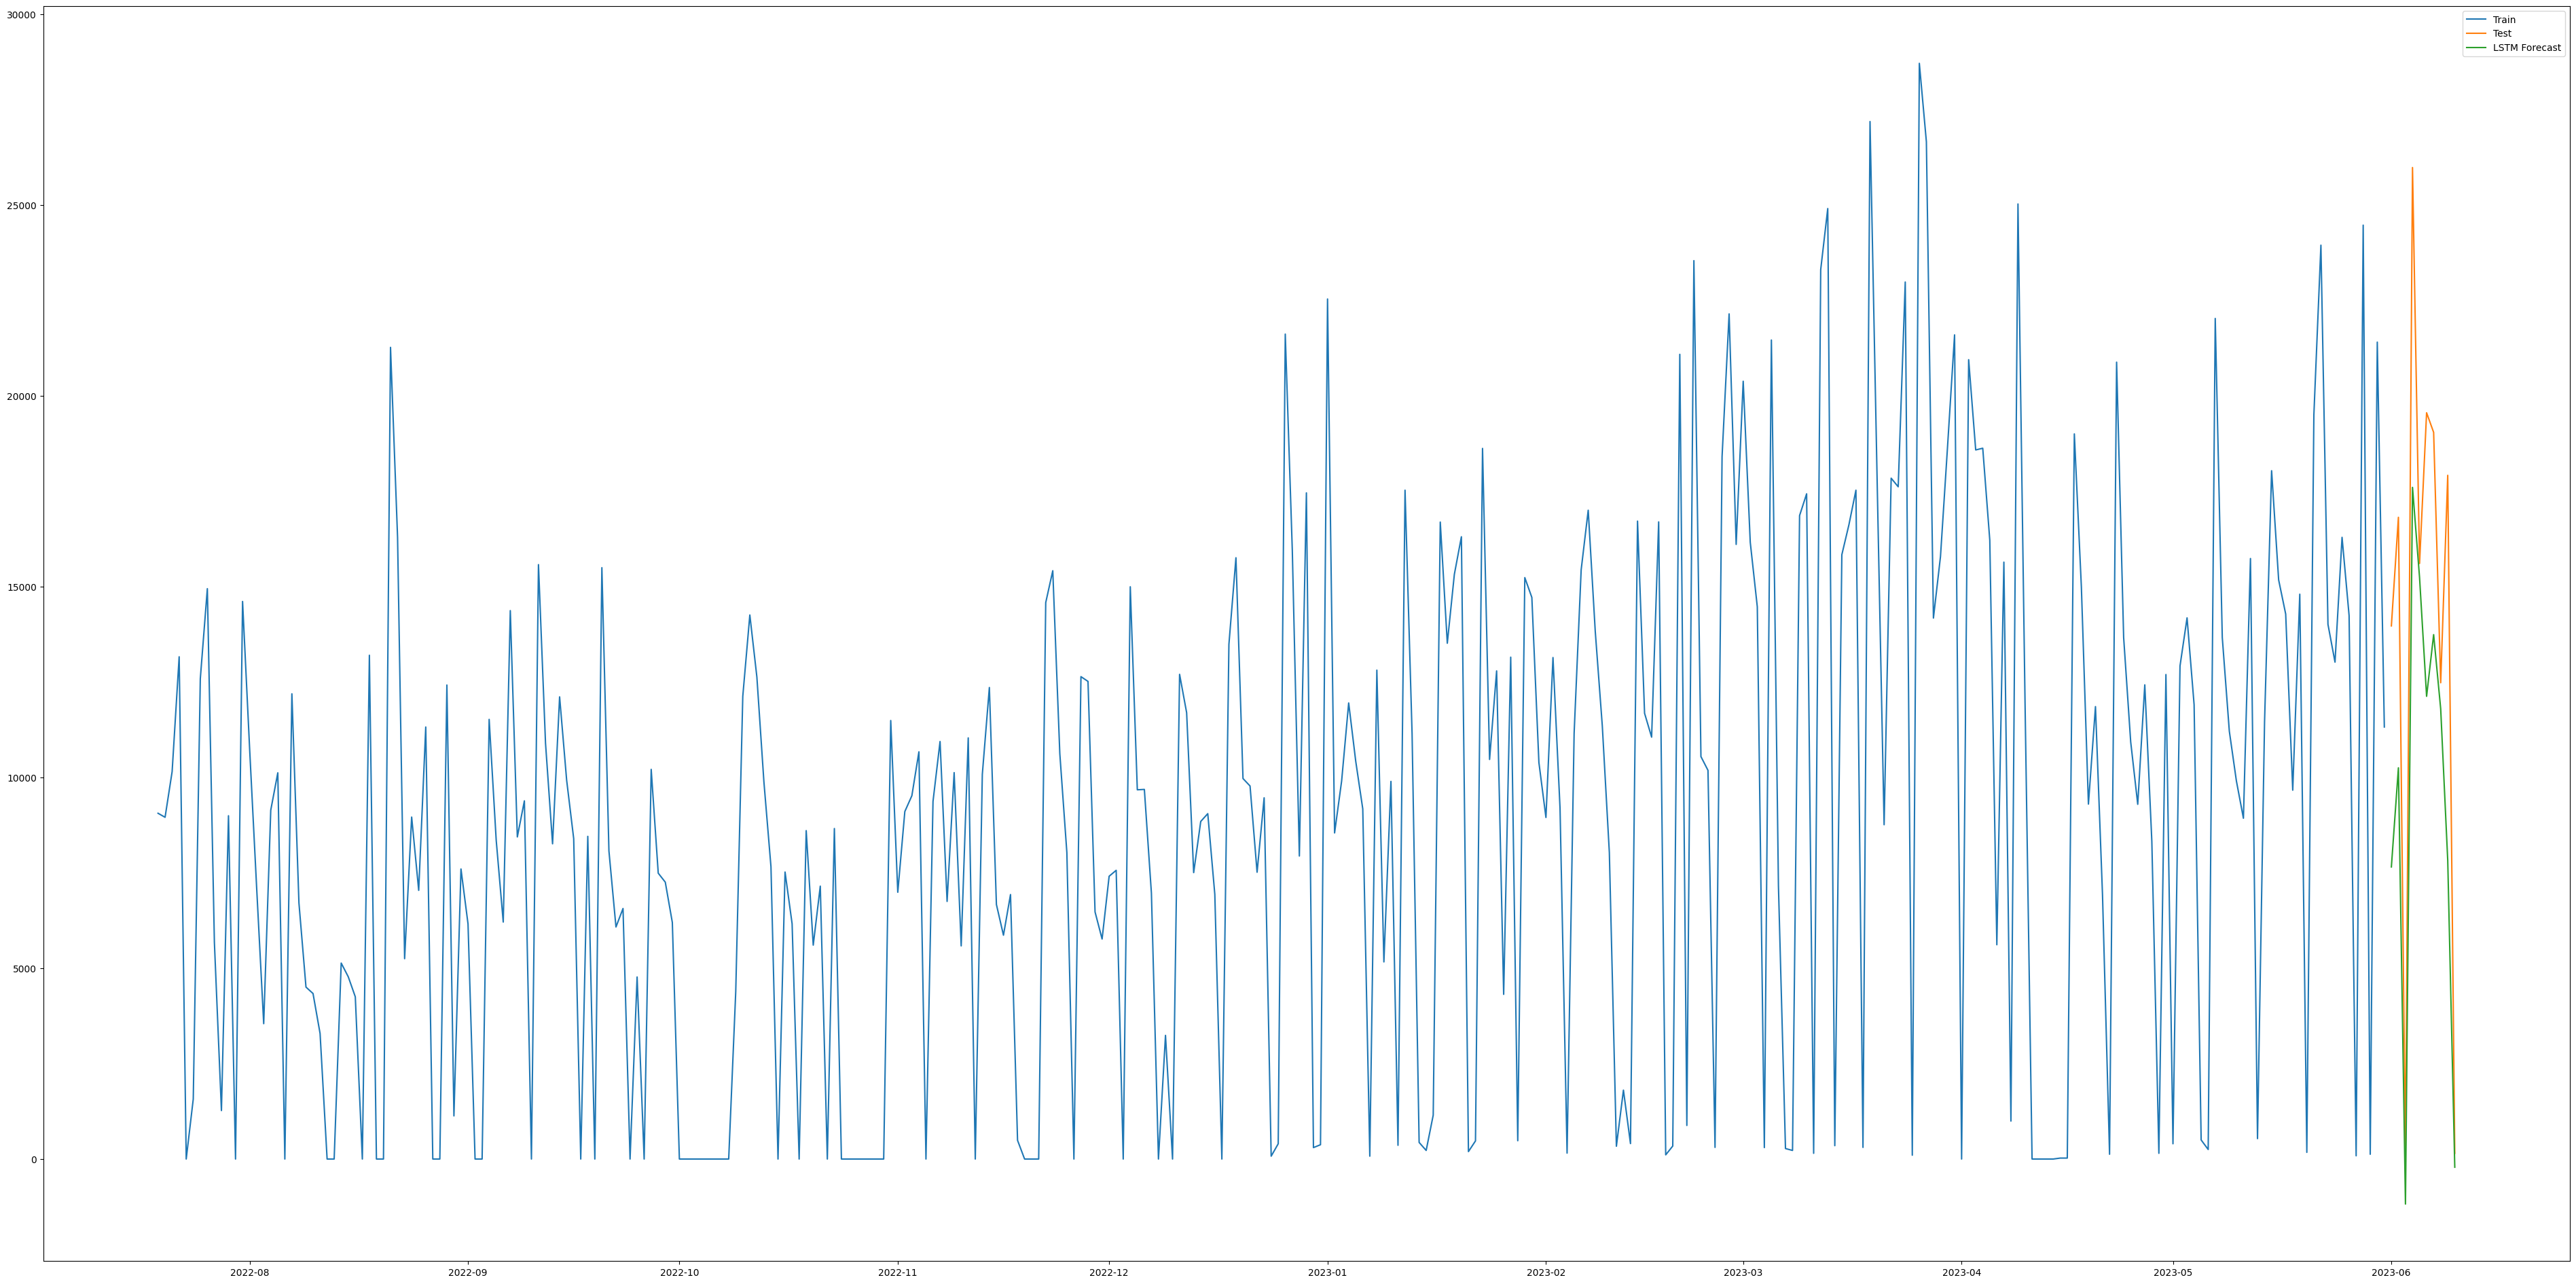

LSTM Model Evaluation:
RMSE: 5836.243750251093
R²: 0.4444469657058838


In [ ]:



train = df[df.index < '2023-06-01']
test = df[df.index >= '2023-06-01']

# Normalize the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[['grand_total', 'is_saturday']])
test_scaled = scaler.transform(test[['grand_total', 'is_saturday']])

# Prepare data for LSTM
n_input = 10  # Number of time steps
n_features = 2  # Number of features

generator = TimeseriesGenerator(train_scaled, train_scaled[:, 0], length=n_input, batch_size=1)

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_input, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(generator, epochs=100, batch_size=32)

# Make predictions
test_predictions = []

first_eval_batch = train_scaled[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[test_scaled[i]]], axis=1)

# Inverse transform predictions
test_predictions = scaler.inverse_transform(np.concatenate((np.array(test_predictions), test_scaled[:, 1:]), axis=1))[:, 0]

# Plot the forecasts
plt.figure(figsize=(48, 24))
plt.plot(train['grand_total'], label='Train')
plt.plot(test['grand_total'], label='Test')
plt.plot(test.index, test_predictions, label='LSTM Forecast')
plt.legend()
plt.show()

# Evaluate the model
print("LSTM Model Evaluation:")
lstm_rmse, lstm_r2 = evaluate_model(test['grand_total'], test_predictions)


In [32]:
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)


# Split the data into train and test sets
train = df[df.index < '2023-06-01']
test = df[df.index >= '2023-06-01']

# Normalize the data including new features
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[['grand_total', 'is_saturday', 'month_sin', 'month_cos', 'day_sin', 'day_cos']])
test_scaled = scaler.transform(test[['grand_total', 'is_saturday', 'month_sin', 'month_cos', 'day_sin', 'day_cos']])

# Prepare data for LSTM
n_input = 10  # Number of time steps
n_features = 6  # Number of features

generator = TimeseriesGenerator(train_scaled, train_scaled[:, 0], length=n_input, batch_size=1)


# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_input, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(generator, epochs=100, batch_size=32)

# Make predictions
test_predictions = []

first_eval_batch = train_scaled[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[test_scaled[i]]], axis=1)

# Inverse transform predictions
test_predictions = scaler.inverse_transform(np.concatenate((np.array(test_predictions), test_scaled[:, 1:]), axis=1))[:, 0]

# Plot the forecasts
plt.figure(figsize=(48, 24))
plt.plot(train['grand_total'], label='Train')
plt.plot(test['grand_total'], label='Test')
plt.plot(test.index, test_predictions, label='LSTM Forecast')
plt.legend()
plt.show()

# Evaluate the model
print("LSTM Model Evaluation:")
lstm_rmse, lstm_r2 = evaluate_model(test['grand_total'], test_predictions)


Epoch 1/100
307/307 [==============================] - 14s 31ms/step - loss: 0.0647
Epoch 2/100
307/307 [==============================] - 9s 29ms/step - loss: 0.0558
Epoch 3/100
307/307 [==============================] - 8s 27ms/step - loss: 0.0559
Epoch 4/100
307/307 [==============================] - 10s 31ms/step - loss: 0.0540
Epoch 5/100
307/307 [==============================] - 9s 30ms/step - loss: 0.0529
Epoch 6/100
307/307 [==============================] - 8s 26ms/step - loss: 0.0499
Epoch 7/100
307/307 [==============================] - 9s 31ms/step - loss: 0.0495
Epoch 8/100
307/307 [==============================] - 10s 31ms/step - loss: 0.0469
Epoch 9/100
307/307 [==============================] - 8s 25ms/step - loss: 0.0477
Epoch 10/100
307/307 [==============================] - 10s 31ms/step - loss: 0.0479
Epoch 11/100
307/307 [==============================] - 10s 31ms/step - loss: 0.0455
Epoch 12/100
307/307 [==============================] - 9s 29ms/step - loss: 0.0

LSTM Model Evaluation:
RMSE: 9114.26313102887
R²: -0.35488303683026334


# LSTM best result in terms of graphs and future prediction
### Created cyclical encoding for month and day input features
### Transformed input features and target features
### trained using LSTM with batch size of 1 for 100 epochs

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from sklearn.metrics import mean_squared_error, r2_score

# Assume df is your DataFrame and already loaded

# Cyclical encoding for month and day
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)

# Split the data into train and test sets
train = df[df.index < '2023-06-01']
test = df[df.index >= '2023-06-01']

# Initialize scalers
feature_scaler = MinMaxScaler()
target_scaler = StandardScaler()

# Fit and transform the training data
train_features = train[['is_saturday', 'month_sin', 'month_cos', 'day_sin', 'day_cos']]
train_target = train[['grand_total']]
train_features_scaled = feature_scaler.fit_transform(train_features)
train_target_scaled = target_scaler.fit_transform(train_target)

# Transform the test data
test_features = test[['is_saturday', 'month_sin', 'month_cos', 'day_sin', 'day_cos']]
test_target = test[['grand_total']]
test_features_scaled = feature_scaler.transform(test_features)
test_target_scaled = target_scaler.transform(test_target)

# Combine scaled features and target for training
train_scaled = np.concatenate([train_target_scaled, train_features_scaled], axis=1)
test_scaled = np.concatenate([test_target_scaled, test_features_scaled], axis=1)

# Prepare data for LSTM
n_input = 10  # Number of time steps
n_features = train_features.shape[1]  # Number of features

generator = TimeseriesGenerator(train_scaled[:, 1:], train_scaled[:, 0], length=n_input, batch_size=1)

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_input, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(generator, epochs=100, batch_size=1)

# Make predictions
test_predictions = []

first_eval_batch = train_scaled[-n_input:, 1:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[test_scaled[i, 1:]]], axis=1)  # Use all features except grand_total

# Inverse transform predictions
test_predictions = target_scaler.inverse_transform(test_predictions)

# Plot the forecasts
plt.figure(figsize=(48, 24))
plt.plot(train.index, train['grand_total'], label='Train')
plt.plot(test.index, test['grand_total'], label='Test')
plt.plot(test.index, test_predictions, label='LSTM Forecast')
plt.legend()
plt.show()

# Evaluate the model
def evaluate_model(true_values, predictions):
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    r2 = r2_score(true_values, predictions)
    return rmse, r2

print("LSTM Model Evaluation:")
lstm_rmse, lstm_r2 = evaluate_model(test['grand_total'], test_predictions)
print(f"RMSE: {lstm_rmse}")
print(f"R^2: {lstm_r2}")



Epoch 1/100
307/307 [==============================] - 11s 30ms/step - loss: 0.9842
Epoch 2/100
307/307 [==============================] - 9s 31ms/step - loss: 0.9344
Epoch 3/100
307/307 [==============================] - 8s 25ms/step - loss: 0.9017
Epoch 4/100
307/307 [==============================] - 9s 30ms/step - loss: 0.8905
Epoch 5/100
307/307 [==============================] - 9s 31ms/step - loss: 0.8702
Epoch 6/100
307/307 [==============================] - 8s 27ms/step - loss: 0.8918
Epoch 7/100
307/307 [==============================] - 9s 28ms/step - loss: 0.8885
Epoch 8/100
307/307 [==============================] - 9s 31ms/step - loss: 0.8645
Epoch 9/100
307/307 [==============================] - 9s 29ms/step - loss: 0.8619
Epoch 10/100
307/307 [==============================] - 8s 25ms/step - loss: 0.8435
Epoch 11/100
307/307 [==============================] - 9s 30ms/step - loss: 0.8255
Epoch 12/100
307/307 [==============================] - 9s 30ms/step - loss: 0.7922


LSTM Model Evaluation:
RMSE: 6406.4236490605035
R^2: 0.3305934007213852


# Generating future 100 days of data using LSTM model above

1/1 [==============================] - 0s 19ms/step


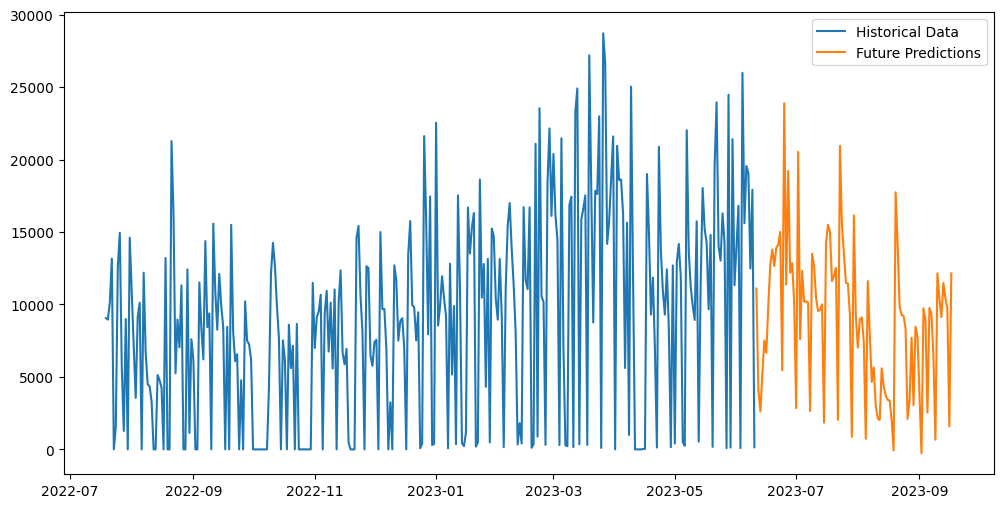

In [52]:
# Generate future dates
last_date = df.index.max()
future_dates = [last_date + timedelta(days=i) for i in range(1, 100)]

# Create a DataFrame
future_df = pd.DataFrame(future_dates, columns=['date'])

# Extract year, month, day, and is_saturday
future_df['year'] = future_df['date'].dt.year
future_df['month'] = future_df['date'].dt.month
future_df['day'] = future_df['date'].dt.day
future_df['is_saturday'] = future_df['date'].dt.dayofweek.apply(lambda x: 1 if x == 5 else 0)

# Cyclical encoding for month and day
future_df['month_sin'] = np.sin(2 * np.pi * future_df['month'] / 12)
future_df['month_cos'] = np.cos(2 * np.pi * future_df['month'] / 12)
future_df['day_sin'] = np.sin(2 * np.pi * future_df['day'] / 31)
future_df['day_cos'] = np.cos(2 * np.pi * future_df['day'] / 31)

# Normalize the future data
future_features = future_df[['is_saturday', 'month_sin', 'month_cos', 'day_sin', 'day_cos']]
future_features_scaled = feature_scaler.transform(future_features)

# Prepare the input for the first prediction
current_batch = train_scaled[-n_input:, 1:].reshape((1, n_input, n_features))

# Predict for the next 30 days
future_predictions = []

for i in range(len(future_features_scaled)):
    current_pred = model.predict(current_batch)[0]
    future_predictions.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[future_features_scaled[i]]], axis=1)

# Inverse transform predictions
future_predictions = target_scaler.inverse_transform(future_predictions)

# Create a DataFrame for plotting
future_df['grand_total'] = future_predictions

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['grand_total'], label='Historical Data')
plt.plot(future_df['date'], future_df['grand_total'], label='Future Predictions')
plt.legend()
plt.show()


# Trying to optimize Sarima model and predicting with it

In [18]:
import itertools

import statsmodels.api as sm


# Cyclical encoding for month and day
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)

# Split the data into train and test sets
train = df[df.index < '2023-06-01']
test = df[df.index >= '2023-06-01']


# Define exogenous variables
train_exog = train[['is_saturday', 'month_sin', 'month_cos', 'day_sin', 'day_cos']]
test_exog = test[['is_saturday', 'month_sin', 'month_cos', 'day_sin', 'day_cos']]


# Define ranges for SARIMA parameters
p = range(1, 3)  # AR order
d = range(1, 3)  # Differencing order
q = range(1, 3)  # MA order
P = range(1, 3)  # Seasonal AR order
D = range(1, 3)  # Seasonal differencing order
Q = range(1, 3)  # Seasonal MA order
s = [12]  # Seasonal period length (assuming monthly data)

# Generate all possible combinations of SARIMA parameters
param_combinations = list(itertools.product(p, d, q, P, D, Q))

best_aic = float("inf")
best_params = None

# Loop through all parameter combinations
for param in param_combinations:
    try:
        # Fit SARIMA model
        sarima_model = sm.tsa.statespace.SARIMAX(train['grand_total'],
                                                 exog=train_exog,
                                                 order=(param[0], param[1], param[2]),
                                                 seasonal_order=(param[3], param[4], param[5], s[0]),
                                                 enforce_stationarity=False,
                                                 enforce_invertibility=False)
        sarima_result = sarima_model.fit()

        # Calculate AIC
        aic = sarima_result.aic

        # Update best parameters if AIC is lower
        if aic < best_aic:
            best_aic = aic
            best_params = param

    except:
        continue

print("Best SARIMA Parameters:", best_params)
print("Best AIC:", best_aic)

Best SARIMA Parameters: (1, 1, 2, 1, 2, 2)
Best AIC: 5675.378709463907


SARIMAX Model Evaluation:
RMSE: 9919.241697027071
R²: -0.6047804516856568
RMSE: 9919.241697027071
R^2: -0.6047804516856568


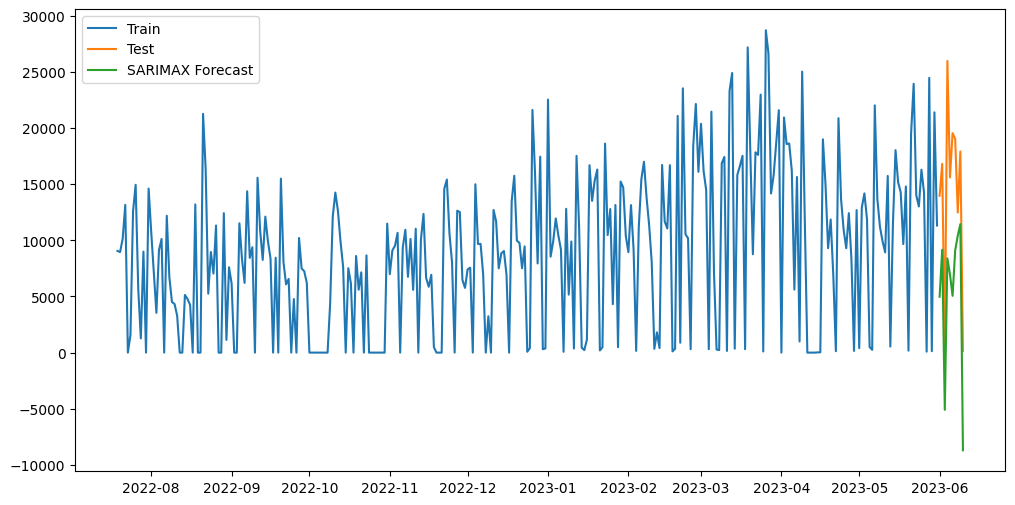

In [19]:
import statsmodels.api as sm
from datetime import datetime, timedelta


# Cyclical encoding for month and day
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)

# Split the data into train and test sets
train = df[df.index < '2023-06-01']
test = df[df.index >= '2023-06-01']

# Define exogenous variables
train_exog = train[['is_saturday', 'month_sin', 'month_cos', 'day_sin', 'day_cos']]
test_exog = test[['is_saturday', 'month_sin', 'month_cos', 'day_sin', 'day_cos']]

# Fit the SARIMAX model
sarimax_model = sm.tsa.statespace.SARIMAX(train['grand_total'],
                                          exog=train_exog,
                                          order=(1, 1, 2),
                                          seasonal_order=(1, 2, 2, 12),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
sarimax_result = sarimax_model.fit()

# Make predictions
sarimax_predictions = sarimax_result.predict(start=len(train), end=len(train) + len(test) - 1, exog=test_exog, dynamic=False)

# Evaluate the model
print("SARIMAX Model Evaluation:")
sarimax_rmse, sarimax_r2 = evaluate_model(test['grand_total'], sarimax_predictions)
print(f"RMSE: {sarimax_rmse}")
print(f"R^2: {sarimax_r2}")

# Plot the forecasts
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['grand_total'], label='Train')
plt.plot(test.index, test['grand_total'], label='Test')
plt.plot(test.index, sarimax_predictions, label='SARIMAX Forecast')
plt.legend()
plt.show()





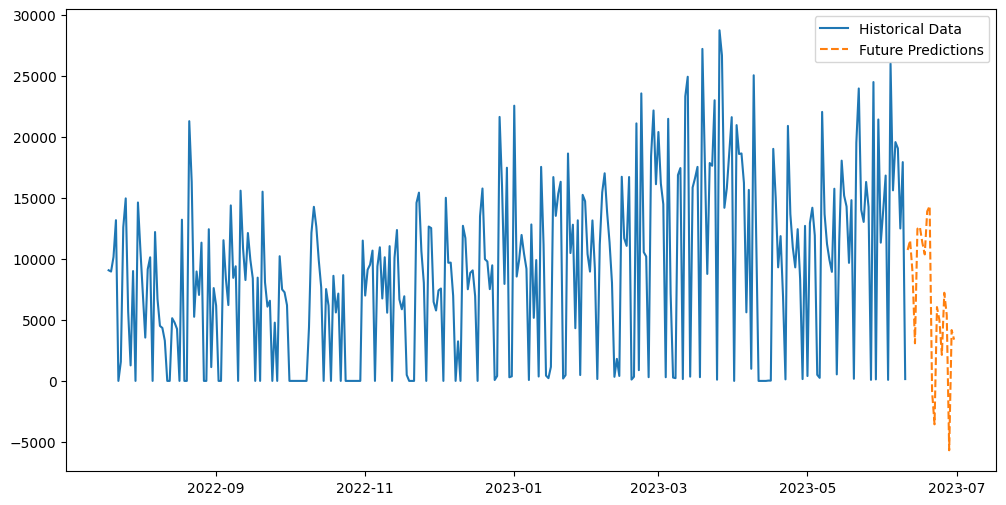

In [20]:
# Generate future dates
last_date = df.index.max()
future_dates = [last_date + timedelta(days=i) for i in range(1, 31)]

# Create a DataFrame for future dates
future_df = pd.DataFrame(future_dates, columns=['date'])
future_df.set_index('date', inplace=True)

# Cyclical encoding for month and day for future dates
future_df['month'] = future_df.index.month
future_df['day'] = future_df.index.day
future_df['is_saturday'] = (future_df.index.weekday == 5).astype(int)
future_df['month_sin'] = np.sin(2 * np.pi * future_df['month'] / 12)
future_df['month_cos'] = np.cos(2 * np.pi * future_df['month'] / 12)
future_df['day_sin'] = np.sin(2 * np.pi * future_df['day'] / 31)
future_df['day_cos'] = np.cos(2 * np.pi * future_df['day'] / 31)

# Define exogenous variables for the future
future_exog = future_df[['is_saturday', 'month_sin', 'month_cos', 'day_sin', 'day_cos']]

# Predict future values
future_forecast = sarimax_result.get_forecast(steps=30, exog=future_exog)
future_forecast_values = future_forecast.predicted_mean

# Create a DataFrame for plotting
future_df['grand_total'] = future_forecast_values

# Plot future forecasts
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['grand_total'], label='Historical Data')
plt.plot(future_df.index, future_df['grand_total'], label='Future Predictions', linestyle='--')
plt.legend()
plt.show()